In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from typing import Tuple
from pathlib import Path
from tqdm.auto import tqdm
import random
import triton.testing as tt

# Add parent directory to path
sys.path.insert(0, "../..")

from hira.index.indexer import CUDAIndexer
from hira.index.searcher import CUDASearcher
from hira.benchmark_area.utils.data_loader import get_real_data
from hira.kernels.triton_wrappers import (
    triton_two_level_filter,
    triton_three_level_filter_v1,
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configs
CONFIG = {
    "initial_keys": 10000,
    "new_keys": 80000,
    "branching_factors": [8],
    "window_sizes": [64, 128, 256, 512, 1024, 2048, 4096],
    "num_runs": 5,
    "dim": 128,
    "device": "cuda",
    "target_results": 10,
    "seed": 42,
    "real_data_path": "../../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "output_csv": "cuda_updating_results.csv",
}

# Results storage
results = []

In [3]:
# TODO: reset the index for warmup and tt.benchmarking
def bench_func(index: CUDAIndexer, warmups, runs):
    pass


def run_benchmark(
    initial_keys: torch.Tensor,
    next_keys: torch.Tensor,
    window_size: int,
    branching_factor: int,
):
    device = torch.device("cuda")
    initial_keys = initial_keys.to(device)
    next_keys = next_keys.to(device)

    # Build index (only once)
    index_two_level = CUDAIndexer(
        depth=CUDAIndexer.DEPTH.TWO_LEVELS,
        max_iterations=1,
        branching_factor=branching_factor,
    ).build(initial_keys)
    index_three_levels = CUDAIndexer(
        depth=CUDAIndexer.DEPTH.THREE_LEVELS,
        max_iterations=1,
        branching_factor=branching_factor,
    ).build(initial_keys)
    index_two_level_v2 = CUDAIndexer(
        depth=CUDAIndexer.DEPTH.TWO_LEVELS,
        max_iterations=1,
        branching_factor=branching_factor,
    ).build(initial_keys)
    index_three_level_v2 = CUDAIndexer(
        depth=CUDAIndexer.DEPTH.THREE_LEVELS,
        max_iterations=1,
        branching_factor=branching_factor,
    ).build(initial_keys)

    build_times_two_level = []
    build_times_three_level = []
    build_times_two_level_v2 = []
    build_times_three_level_v2 = []

    methods = {
        "two_level": (index_two_level, build_times_two_level),
        "three_levels": (index_three_levels, build_times_three_level),
        "two_level_v2": (index_two_level_v2, build_times_two_level_v2),
        "three_levels_v2": (index_three_level_v2, build_times_three_level_v2),
    }

    # break next_keys into chunks of size window_size
    chunks = [
        next_keys[i : i + window_size]
        for i in range(0, next_keys.shape[0], window_size)
    ]

    first_chunk = True
    for chunk in tqdm(chunks, desc="Chunks"):
        method_names = list(methods.keys())
        random.shuffle(method_names)

        if first_chunk:
            # ignore first call (triton overhead)
            for method_name in method_names:
                method, _ = methods[method_name]
                if "v2" in method_name:
                    method.update(chunk)
                else:
                    method.update_v1(chunk)
            first_chunk = False
            continue

        for method_name in method_names:
            torch.cuda.synchronize()
            method, times = methods[method_name]
            start_time = time.time()
            if "v2" in method_name:
                method.update(chunk)
            else:
                method.update_v1(chunk)
            end_time = time.time()
            times.append(end_time - start_time)

    avg_build_time_two_level = sum(build_times_two_level) / len(build_times_two_level)
    avg_build_time_three_level = sum(build_times_three_level) / len(
        build_times_three_level
    )
    avg_build_time_two_level_v2 = sum(build_times_two_level_v2) / len(
        build_times_two_level_v2
    )
    avg_build_time_three_level_v2 = sum(build_times_three_level_v2) / len(
        build_times_three_level_v2
    )

    return (
        avg_build_time_two_level,
        avg_build_time_three_level,
        avg_build_time_two_level_v2,
        avg_build_time_three_level_v2,
    )


print("functions defined!")

functions defined!


In [4]:
import os
import faiss
from contextlib import contextmanager

@contextmanager
def silence_fd2():
    """
    Redirect OS-level stderr (fd=2). This suppresses C/C++ prints (FAISS warnings).
    """
    # Save a copy of the original stderr fd
    old_fd = os.dup(2)
    try:
        # Point fd=2 to /dev/null
        devnull = os.open(os.devnull, os.O_WRONLY)
        os.dup2(devnull, 2)
        os.close(devnull)
        yield
    finally:
        # Restore original fd=2
        os.dup2(old_fd, 2)
        os.close(old_fd)

# Monkey-patch Kmeans.train
_orig_train = faiss.Kmeans.train

def silent_train(self, x):
    with silence_fd2():
        return _orig_train(self, x)

faiss.Kmeans.train = silent_train


### Benchmark

In [5]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Load keys
fixed_keys = get_real_data(
    CONFIG["initial_keys"] + CONFIG["new_keys"],
    CONFIG['dim'],
    seed=CONFIG['seed'],
    real_data_path=CONFIG['real_data_path']
)

for branching_factor in CONFIG['branching_factors']:
    print(f"\nBranching Factor: {branching_factor}")

    for window_size in CONFIG['window_sizes']:
        print(f"Window Size: {window_size:,}")
            
        initial_keys = fixed_keys[:CONFIG["initial_keys"]]
        next_keys = fixed_keys[CONFIG["initial_keys"]:]
        
        # warm up
        print("Warming up...")
        for _ in range(2):
            run_benchmark(
                initial_keys=initial_keys,
                branching_factor=branching_factor,
                next_keys=next_keys,
                window_size=window_size,
            )
        print("Starting benchmark runs...")
        for _ in range(CONFIG["num_runs"]):
            build_time_two_levels, build_time_three_levels, build_time_two_levels_v2, build_time_three_levels_v2 = run_benchmark(
                initial_keys=initial_keys,
                branching_factor=branching_factor,
                next_keys=next_keys,
                window_size=window_size,
            )
        
            result = {
                'branching_factor': branching_factor,
                'window_size': window_size,
                'build_time_two_levels': build_time_two_levels,
                'build_time_three_levels': build_time_three_levels,
                'build_time_two_levels_v2': build_time_two_levels_v2,
                'build_time_three_levels_v2': build_time_three_levels_v2,
            }
            
            results.append(result)
            
        # Save intermediate results to CSV after each experiment
        pd.DataFrame(results).to_csv(output_csv, index=False)

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nResults saved to: {output_csv.absolute()}")

  Loading real data from: ../../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 90000 real keys (dimension=128)

Branching Factor: 8
Window Size: 64
Warming up...


Chunks: 100%|██████████| 1250/1250 [00:12<00:00, 103.64it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 1250/1250 [00:12<00:00, 103.09it/s]


Window Size: 128
Warming up...


Chunks: 100%|██████████| 625/625 [00:07<00:00, 79.86it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 625/625 [00:07<00:00, 80.00it/s]


Window Size: 256
Warming up...


Chunks: 100%|██████████| 313/313 [00:05<00:00, 56.39it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 313/313 [00:05<00:00, 56.49it/s]


Window Size: 512
Warming up...


Chunks: 100%|██████████| 157/157 [00:04<00:00, 36.18it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 157/157 [00:04<00:00, 36.15it/s]


Window Size: 1,024
Warming up...


Chunks: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 79/79 [00:03<00:00, 19.94it/s]


Window Size: 2,048
Warming up...


Chunks: 100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Window Size: 4,096
Warming up...


Chunks: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Starting benchmark runs...


Chunks: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Results saved to: /home/mohsen/kvcache/hira/benchmark_area/updating_index/cuda/cuda_updating_results.csv
CPU times: user 8min 18s, sys: 3.89 s, total: 8min 21s
Wall time: 6min 30s


### Visualization

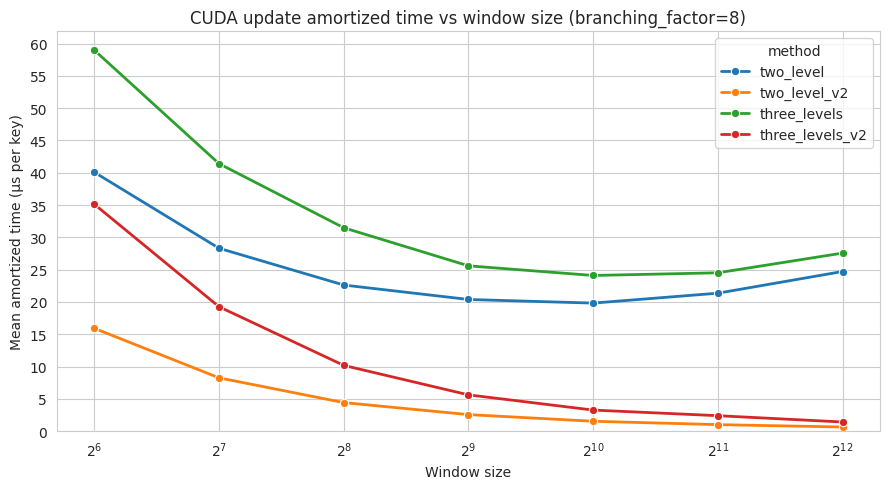

Loaded 35 rows from cuda_updating_results.csv
Plotting branching_factor=8; window_sizes=[64, 128, 256, 512, 1024, 2048, 4096]


In [9]:
# Plot amortized update time (time per key) vs window_size for a fixed branching factor,
# with three lines: two_level vs two_level_v2 vs three_levels

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

csv_path = Path(CONFIG.get("output_csv", "cuda_updating_results.csv"))
df = pd.read_csv(csv_path)

required = [
    "branching_factor",
    "window_size",
    "build_time_two_levels",
    "build_time_two_levels_v2",
    "build_time_three_levels_v2",
    "build_time_three_levels",
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(
        f"Missing columns in {csv_path}: {missing}. Found: {list(df.columns)}"
    )

# Ensure numeric types
for c in required:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=required).copy()

# Choose branching factor to plot (edit as desired)
fixed_bf = 8
if fixed_bf not in set(df["branching_factor"].astype(int)):
    fixed_bf = int(df["branching_factor"].iloc[0])
fixed_bf = int(fixed_bf)

view = df[df["branching_factor"] == fixed_bf].copy()

# Build long-form table with one row per (run, window_size, method)
two = view[["window_size", "build_time_two_levels"]].copy()
two["method"] = "two_level"
two["us_per_key"] = (two["build_time_two_levels"] * 1e6) / two["window_size"]

two_v2 = view[["window_size", "build_time_two_levels_v2"]].copy()
two_v2["method"] = "two_level_v2"
two_v2["us_per_key"] = (two_v2["build_time_two_levels_v2"] * 1e6) / two_v2[
    "window_size"
]

three = view[["window_size", "build_time_three_levels"]].copy()
three["method"] = "three_levels"
three["us_per_key"] = (three["build_time_three_levels"] * 1e6) / three["window_size"]

three_v2 = view[["window_size", "build_time_three_levels_v2"]].copy()
three_v2["method"] = "three_levels_v2"
three_v2["us_per_key"] = (three_v2["build_time_three_levels_v2"] * 1e6) / three_v2[
    "window_size"
]

long = pd.concat(
    [
        two[["window_size", "method", "us_per_key"]],
        two_v2[["window_size", "method", "us_per_key"]],
        three[["window_size", "method", "us_per_key"]],
        three_v2[["window_size", "method", "us_per_key"]],
    ],
    ignore_index=True,
)

# Aggregate across runs
agg = (
    long.groupby(["window_size", "method"], as_index=False)
    .agg(
        mean_us=("us_per_key", "mean"),
        std_us=("us_per_key", "std"),
        n=("us_per_key", "size"),
    )
    .sort_values(["method", "window_size"])
)

plt.figure(figsize=(9, 5))
sns.lineplot(
    data=agg,
    x="window_size",
    y="mean_us",
    hue="method",
    hue_order=["two_level", "two_level_v2", "three_levels", "three_levels_v2"],
    marker="o",
    linewidth=2,
    errorbar=None,
)
plt.ylim(bottom=0)
plt.yticks(np.arange(0, agg["mean_us"].max() * 1.1, step=5))
plt.title(f"CUDA update amortized time vs window size (branching_factor={fixed_bf})")
plt.xlabel("Window size")
plt.ylabel("Mean amortized time (µs per key)")
plt.xscale("log", base=2)
plt.legend(title="method")
plt.tight_layout()

plt.show()

print(f"Loaded {len(df)} rows from {csv_path}")
print(
    f"Plotting branching_factor={fixed_bf}; window_sizes={sorted(view['window_size'].unique().astype(int).tolist())}"
)